In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa, librosa.display
import miditoolkit
import pypianoroll

In [3]:
gt_midi = '../../../maestro-v3.0.0/Original/2015/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--3.midi'
#seghop_duration = 4410/44100
#paudio_duration = librosa.get_duration(y=gt_midi.replace('.midi', '.wav'), sr=44100)
#n_frames = int(np.ceil(paudio_duration/seghop_duration))

gt = miditoolkit.midi.parser.MidiFile(gt_midi)
tick = gt.ticks_per_beat
tempo = int(gt.tempo_changes[0].tempo)
cc = gt.instruments[0].control_changes
#gt_onset = []
#gt_offset = []
time = []
ped = []
is_on = False
for msg in cc:
    if msg.number == 64 and msg.value > 0:  #  and not is_on
        #gt_onset.append(msg.time)
        time.append(msg.time)
        ped.append(1)
        is_on = True
        
    elif msg.number == 64 and msg.value == 0:  #  and is_on
        #gt_offset.append(msg.time)
        time.append(msg.time)
        ped.append(0)
        is_on = False

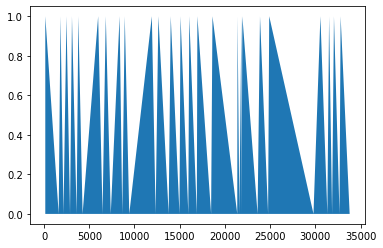

In [142]:
est_midi = './transcribed/MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--1.mid'

est = miditoolkit.midi.parser.MidiFile(est_midi)
tick = gt.ticks_per_beat
tempo = int(est.tempo_changes[0].tempo)
cc = est.instruments[0].control_changes
#gt_onset = []
#gt_offset = []
est_time = []
est_ped = []
is_on = False
for msg in cc:
    if msg.number == 64 and msg.value > 0:  #  and not is_on
        #gt_onset.append(msg.time)
        est_time.append(msg.time)
        est_ped.append(1)
        is_on = True
        
    elif msg.number == 64 and msg.value == 0:  #  and is_on
        #gt_offset.append(msg.time)
        est_time.append(msg.time)
        est_ped.append(0)
        is_on = False
    
plt.figure()
plt.fill_between(np.array(est_time[:50]), 0, np.array(est_ped[:50]))
#plt.plot(np.array(est_ped[:50]), np.array(est_time[:50]))

In [130]:
est_time[49]

33792

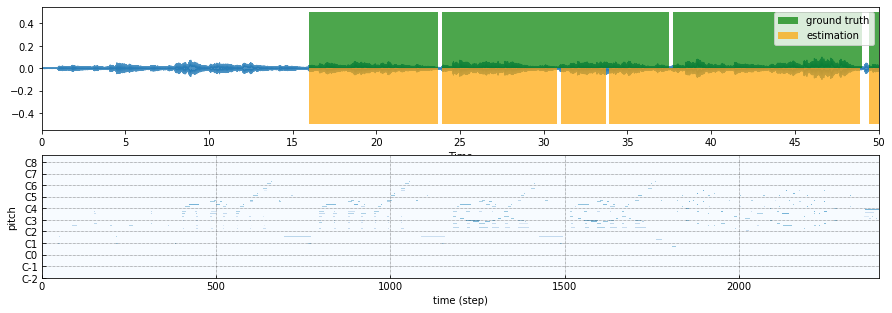

In [60]:
paudio_path = gt_midi.replace('.midi', '.wav')
paudio, sr = librosa.load(paudio_path, sr=44100) 

#end = int((time[:4000][-1]//tick) * 60/tempo)
#start = 30
end = 50
left,right = [0,end]
fig, axs = plt.subplots(2, 1, figsize=(15,5))
librosa.display.waveplot(paudio, SR, alpha=0.8, ax=axs[0])
axs[0].fill_between(frmtimes, 0, 0.5, where=segframes_gt>0, facecolor='green', alpha=0.7, label='ground truth')
axs[0].fill_between(frmtimes, -0.5, 0, where=segframes_est>0, facecolor='orange', alpha=0.7, label='estimation')
#axs[0].title("Pedal segment detection of {}".format(filename))
axs[0].legend()
axs[0].set_xlim([left,right])

roll = pypianoroll.read(gt_midi)
tempo = int(roll.tempo[0])
time_step = roll.resolution
length = ((tempo // 60) * time_step) * end
#head = ((tempo // 60) * time_step) * start
pypianoroll.plot_pianoroll(pianoroll=roll.tracks[0].pianoroll[:length], ax=axs[1])

fig.savefig('../image/test2_trans.png', dpi=400)

In [8]:
import pretty_midi
import os

transcribed = os.listdir('./transcribed/midi')
for songs in transcribed:
    print('Processing {}'.format(songs))
    #est_midi = './transcribed/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--4.mid'
    est_midi = os.path.join('./transcribed/midi', songs)
    pm = pretty_midi.PrettyMIDI(est_midi)

    pedal_v = []
    pedal_t = []
    filenames=[]
    pedal_onsets=[]
    pedal_offsets=[]
    for control_change in pm.instruments[0].control_changes:
        if control_change.number == 64:
            pedal_v.append(control_change.value)
            pedal_t.append(control_change.time)

    pedal_onset = []
    pedal_offset = []
    for i,v in enumerate(pedal_v):
        if i>0 and v>=64 and pedal_v[i-1]<64:
            pedal_onset.append(pedal_t[i])   
        elif i>0 and v<64 and pedal_v[i-1]>=64:
            pedal_offset.append(pedal_t[i])

    pedal_offset = [t for t in pedal_offset if t > pedal_onset[0]]
    seg_idxs = np.min([len(pedal_onset), len(pedal_offset)])
    pedal_offset = pedal_offset[:seg_idxs]
    pedal_onset = pedal_onset[:seg_idxs]
    for seg_idx, offset in enumerate(pedal_offset):
        if offset != pedal_offset[-1] and offset > pedal_onset[seg_idx] and offset < pedal_onset[seg_idx+1]:
            correct_pedal_data = True
        elif offset == pedal_offset[-1] and offset > pedal_onset[seg_idx]:
            correct_pedal_data = True
        else:
            correct_pedal_data = False

    if correct_pedal_data:
        filenames.append('test')
        pedal_onsets.append(pedal_onset)
        pedal_offsets.append(pedal_offset)

    #print('Saving {} filenames.'.format(len(filenames)))
    np.savez(os.path.join('./transcribed/pedal-times-npz', songs.replace('mid', '')), 
         filename=filenames, pedal_onset=pedal_onsets, pedal_offset=pedal_offsets)
print('Done!')

Processing MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_11_R1_2014_wav--1.mid
Processing MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--2.mid
Processing MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--2.mid
Processing MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--5.mid
Processing MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--1.mid
Processing MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--2.mid
Processing MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--5.mid
Processing MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--2.mid
Processing MIDI-Unprocessed_Recital16_MID--AUDIO_16_R1_2018_wav--3.mid
Processing MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--3.mid
Processing MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--1.mid
Processing MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_06_R1_2015_wav--6.mid
Processing MIDI-Unprocessed_083_PIANO083

In [54]:
npz_path = os.path.join('./transcribed', 'pedal-times-t2.npz')
tracks = np.load(npz_path, allow_pickle=True)
pedal_offset_est_tracks = tracks['pedal_offset']
pedal_onset_est_tracks = tracks['pedal_onset']

pedal_offset_est = np.array(pedal_offset_est_tracks[0])
pedal_onset_est = np.array(pedal_onset_est_tracks[0])

In [25]:
def intervals1tointervals01(segintervals1, paudio_duration):
    idx2del = []
    for idx in np.arange(1,len(segintervals1)):
        if segintervals1[idx-1][1] >= segintervals1[idx][0]:
            segintervals1[idx] = [segintervals1[idx-1][0],segintervals1[idx][1]]
            idx2del.append(idx-1)           
    segintervals1 = np.delete(segintervals1, idx2del, axis=0)  
    
    labels = []
    segintervals01 = np.zeros((len(segintervals1)*2+1,2))
    
    for idx in range(len(segintervals01)):
        if idx==0:
            segintervals01[idx] = [0, segintervals1[0][0]]
            labels.append('np')
        elif idx==len(segintervals01)-1:
            segintervals01[idx] = [segintervals1[-1][-1],paudio_duration]
            labels.append('np')
        elif idx%2:
            segintervals01[idx] = segintervals1[int(np.floor(idx/2))]
            labels.append('p')
        else:
            segintervals01[idx] = [segintervals1[int(np.floor(idx/2)-1)][-1],segintervals1[int(np.floor(idx/2))][0]]
            labels.append('np')
            
    idx2del = []
    for idx, seginterval in enumerate(segintervals01):
        if seginterval[0]==seginterval[1]:
            idx2del.append(idx)
    segintervals01 = np.delete(segintervals01, idx2del, axis=0)
    labels = np.delete(labels, idx2del)
    
    return segintervals1, segintervals01, labels

In [55]:
gt_midi = '../../../maestro-v3.0.0/Original/2014/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--4.midi'

In [56]:
SR = 44100
seghop_duration = 4410/44100
paudio_path = gt_midi.replace('.midi', '.wav')
paudio, sr = librosa.load(paudio_path, sr=44100) 

paudio_duration = librosa.get_duration(y=paudio, sr=SR)
n_frames = int(np.ceil(paudio_duration/seghop_duration))
segframes_est = np.zeros(n_frames)
segframes_est = np.zeros(n_frames)

longpseg_idx = np.where((pedal_offset_est-pedal_onset_est)>seghop_duration)[0]
longseg_onset_est = pedal_onset_est[longpseg_idx]
longseg_offset_est = pedal_offset_est[longpseg_idx]
segintervals_est = np.stack((longseg_onset_est,longseg_offset_est), axis=-1)

for idx, onset_t in enumerate(longseg_onset_est):
    offset_t = longseg_offset_est[idx]
    onset_frm = int(onset_t//seghop_duration)
    offset_frm = int(offset_t//seghop_duration)
    segframes_est[onset_frm:offset_frm] = 1



In [57]:
frmtimes = np.arange(n_frames)*seghop_duration

In [58]:
npz_path = os.path.join('./test', 'pedal-times-t2.npz')
tracks = np.load(npz_path, allow_pickle=True)
pedal_offset_gt_tracks = tracks['pedal_offset']
pedal_onset_gt_tracks = tracks['pedal_onset']

pedal_offset_gt = np.array(pedal_offset_gt_tracks[0])
pedal_onset_gt = np.array(pedal_onset_gt_tracks[0])

In [59]:
SR = 44100
seghop_duration = 4410/44100
paudio_path = gt_midi.replace('.midi', '.wav')
paudio, sr = librosa.load(paudio_path, sr=44100) 

paudio_duration = librosa.get_duration(y=paudio, sr=SR)
n_frames = int(np.ceil(paudio_duration/seghop_duration))
segframes_gt = np.zeros(n_frames)
segframes_gt = np.zeros(n_frames)

longpseg_idx = np.where((pedal_offset_gt-pedal_onset_gt)>seghop_duration)[0]
longseg_onset_gt = pedal_onset_gt[longpseg_idx]
longseg_offset_gt = pedal_offset_gt[longpseg_idx]
segintervals_gt = np.stack((longseg_onset_gt,longseg_offset_gt), axis=-1)

for idx, onset_t in enumerate(longseg_onset_gt):
    offset_t = longseg_offset_gt[idx]
    onset_frm = int(onset_t//seghop_duration)
    offset_frm = int(offset_t//seghop_duration)
    segframes_gt[onset_frm:offset_frm] = 1
